# Datos de Mercatenerife
Vamos a empezar bajando todos los pdfs desde la página de Mercatenerife

In [1]:
import requests
import os

months = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
categories = {'KILOS':'Kilogramos', 'PRECIOS':'Precios'}

def pdfDownload(url, target_path):
    response = requests.get(url)
    if response.status_code == 404:
        response = requests.get(url.replace('_', '-'))
    if response.status_code == 404:
        response = requests.get(url.replace('_', '%20'))
    if response.status_code == 404:
        url_array = url.split('/')
        name_array = url_array[-1].split('_')
        file_name = (name_array[2][:-4] + '-' + name_array[0] + '-' 
                     + name_array[1] + name_array[2][-4:])
        url = '/'.join(url_array[0:-1]) + '/' + file_name
        response = requests.get(url)
    with open(target_path, "wb") as code:
        code.write(response.content)

In [6]:
for category in categories.keys():
    # os.mkdir(f'{category}')
    
    for year in years:
        
        for month in months:
            
            url = f'https://mercatenerife.com/download/{categories[category]}/{year}/{category}_{month}_{year}.pdf'
            target_path = f'{category}/{category}_{month}_{year}.pdf'
            pdfDownload(url, target_path)

# Conversion PDF a CSV
Convertí los PDFs a xlsx con el software Smallpdf

# Let's read the csvs

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

months = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']

def parseStr(string):
    str_array = string.split(' ')
    filtered_white_space = list(filter(lambda x: x != '', str_array))
    converted_numbers = list(map(lambda x: x.replace('.', ''), filtered_white_space))
    words = []
    for elem in converted_numbers:
        if not elem.isnumeric():
            words.append(elem)
    name = ' '.join(words)
    output = [converted_numbers[0]] + [name] + converted_numbers[len(words) + 1:]
    return output

def extractKILOSDataList(tables):
    data_list = []
    def convert_number(x):
        """
        Original numbers contained dots to separate units, e.g. 3.000 for 3 thousand
        That's unfortunate, because 0's are lost during conversion and I get 3 instead!
        This function finds the dots and fills in the zeros. The converts back to integer
        """
        s_array = str(x).split('.')
        last_elem = s_array[-1]
        if not (len(last_elem) == 1 and last_elem == '0'):
            while len(last_elem) < 3:
                last_elem += '0'
            s_array[-1] = last_elem
            return int(''.join(s_array))
        else:
            return int(s_array[0])
        
        
    for key in tables:
        df = tables[key]
        for i in range(df.shape[0]):
            data = df.iloc[i,:].dropna(0)
            try:
                if type(data.iloc[0]) == str:
                    array = parseStr(data.iloc[0])
                elif type(data.iloc[0]) == int or type(data.iloc[0]) == np.int64:
                    array = data.values.tolist()
                if len(array) == 11:
                    data_list.append([int(array[0])] + [array[1]] + [convert_number(elem) for elem in array[2:]])         
            except:
                pass
    return data_list

def extractPRECIOSDataList(tables):
    data_list = []
    for key in tables:
        df = tables[key]
        for i in range(df.shape[0]):
            data = df.iloc[i,:].dropna()
            if len(data) == 6 and (type(data[0]) == int or type(data[0]) == np.int64):
                data_list.append(data.values.tolist())
    return data_list

def getDictOfProductCodes(data):
    months = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 
              'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 
              'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
    years = ['2013', '2014', '2015', '2016', 
             '2017', '2018', '2019']
    codes = {}
    for year in years:
        for month in months:
            df = data[year][month]
            for i, row in df.iterrows():
                if row.codigo not in codes.keys():
                    codes[row.codigo] = row.nombre
    sorted_codes = {}
    sorted_values = list(codes.values())
    sorted_values.sort()
    inverse_codes = {codes[key]: key for key in codes.keys()}
    sorted_codes = {inverse_codes[value]: value for value in sorted_values}
    return sorted_codes

def extractKilosTimeSeries(dataKILOS, codigo):
    kilos = {'local': {}, 'importacion': {}}
    for year in years:
        for month in months:
            date = f'{month}_{year}'
            try:
                df = dataKILOS[year][month]
                kilos['local'][date] = df.loc[df.codigo == codigo, 'local_total'].iat[0]
                kilos['importacion'][date] = df.loc[df.codigo == codigo, 'importacion_total'].iat[0]
            except:
                kilos['local'][date] = 0
                kilos['importacion'][date] = 0
    return kilos

def extractPrecioTimeSeries(dataPRECIOS, codigo):
    precios = {'min': {'local': {}, 'importacion': {}}, 
               'max': {'local': {}, 'importacion': {}}, 
               'moda': {'local': {}, 'importacion': {}}
               #,'fechas': []
              }
    translate_origin = lambda x: 'local' if x in 'LOCAL' else 'importacion'
               
    for year in years:
        for month in months:
            date = f'{month}_{year}'
            try:
                data = dataPRECIOS[year][month]
                origen_indices = data.origen[data['codigo'] == codigo].to_dict()
                #precios['fechas'].append(f'{month}_{year}')

                for index in origen_indices.keys():
                    origen = translate_origin(origen_indices[index])
                    precios['max'][origen][date] = data.loc[index, 'maximo']
                    precios['min'][origen][date] = data.loc[index, 'minimo']
                    precios['moda'][origen][date] = data.loc[index, 'moda']

                if len(origen_indices) < 2:
                    if list(origen_indices.values())[0] in 'LOCAL':
                        missing_origen = 'importacion'
                    else: 
                        missing_origen = 'local'

                    precios['max'][missing_origen][date] = np.nan
                    precios['min'][missing_origen][date] = np.nan
                    precios['moda'][missing_origen][date] = np.nan
            except:
                for origen in ['local', 'importacion']:
                    precios['max'][origen][date] = np.nan
                    precios['min'][origen][date] = np.nan
                    precios['moda'][origen][date] = np.nan
    return precios

def findMaximalProductionMonths(producto):
    kilos = extractKilosTimeSeries(dataKILOS, producto)
    series_local = np.array(list(kilos['local'].values()))
    series_impor = np.array(list(kilos['importacion'].values()))
    n_steps = len(series_local)
    
    # Select local or imported based on number of nonzero entries
    if len(np.where(series_local == 0)[0]) > 0.75 * n_steps:
        series = series_impor
    else:
        series = series_local
    
    # Find minimum peak height across months
    sorted_series = series.copy()
    sorted_series.sort()
    min_peak = sorted_series[::-1][:11].min()
    fechas = np.array(list(kilos['local'].keys()))
    
    # Find peaks
    try:
        peaks, _ = find_peaks(series, width=1.5, height=1 * min_peak)
        best_months = np.unique([fecha.split('_')[0] for fecha in fechas[peaks]]).tolist()
        best_months.sort(key=month_index)
        if len(best_months) > 1:
            return [best_months[0], best_months[-1]]
        else:
            return best_months[0]  
    except:
        return []

In [2]:
dataKILOS = {}
header = ['codigo', 'nombre', 'importacion_mayorista', 'local_mayorista', 'total_mayorista', 
          'importacion_agricultores', 'local_agricultores', 'total_agricultores', 
          'importacion_total', 'local_total', 'total_total']

for year in years:
    dataKILOS[year] = {}
    for month in months:
        target_path = f'KILOS_csv/KILOS_{month}_{year}.xlsx'
        tables = pd.read_excel(target_path, sheet_name=None, header=None)
        try:
            data_list = extractKILOSDataList(tables)
            dataKILOS[year][month] = pd.DataFrame(data_list, columns=header)
        except:
            dataKILOS[year][month] = 'FAILED'
            print(f'Failed: {year}, {month}')
        
dataKILOS['2019']['AGOSTO'].head()

,codigo,nombre,importacion_mayorista,local_mayorista,total_mayorista,importacion_agricultores,local_agricultores,total_agricultores,importacion_total,local_total,total_total
0,10102,AGUACATES FUERTES,0,2761,2761,0,3802,3802,0,6563,6563
1,10103,AGUACATE HASS,600,36665,37265,0,15041,15041,600,51706,52306
2,10200,ALBARICOQUES,12558,0,12558,0,0,0,12558,0,12558
3,10300,BREVAS,0,0,0,0,490,490,0,490,490
4,10600,CEREZAS,4855,0,4855,0,0,0,4855,0,4855


In [12]:
dataPRECIOS = {}
header = ['codigo', 'nombre', 'origen', 'minimo', 'maximo', 'moda']

for year in years:
    dataPRECIOS[year] = {}
    for month in months:
        target_path = f'PRECIOS_csv/PRECIOS_{month}_{year}.xlsx'
        tables = pd.read_excel(target_path, sheet_name=None, header=None)
        try:
            data_list = extractPRECIOSDataList(tables)
            dataPRECIOS[year][month] = pd.DataFrame(data_list, columns=header)
        except:
            dataPRECIOS[year][month] = 'FAILED'
            print(f'Failed: {year}, {month}')
            
dataPRECIOS['2016']['MAYO'].head()

,codigo,nombre,origen,minimo,maximo,moda
0,10102,AGUACATES FUERTES,LOCAL,2.60,3.4,2.80
1,10103,AGUACATE HASS,LOCAL,3.00,4.0,3.60
2,10200,ALBARICOQUES,NO LOCAL,1.95,3.4,2.25
3,10600,CEREZAS,NO LOCAL,10.00,15.0,12.00
4,10602,CEREZAS PICOTAS,NO LOCAL,6.00,6.0,6.00


In [17]:
codigos = getDictOfProductCodes(dataKILOS)

In [20]:
# Let's get time series for all products
kilosTimeSeries = {}
preciosTimeSeries = {}
for producto in codigos.keys():
    kilosTimeSeries[producto] = extractKilosTimeSeries(dataKILOS, producto)
    preciosTimeSeries[producto] = extractPrecioTimeSeries(dataPRECIOS, producto)

In [103]:
# Compute fraction of total products produced on the island
total_kilos_locales, total_kilos_importados = 0, 0
for producto in kilosTimeSeries.keys():
    total_kilos_locales += sum(list(kilosTimeSeries[producto]['local'].values()))
    total_kilos_importados += sum(list(kilosTimeSeries[producto]['importacion'].values()))
fraction_local = total_kilos_locales / (total_kilos_locales + total_kilos_importados)
print(f'En total se han producido {100 * fraction_local:.2f}% de los productos en Tenerife desde 2013.')

En total se han producido 41.08% de los productos en Tenerife desde 2013.


In [111]:
year = '2017'
producto = 10102
series_total = kilosTimeSeries[producto]['local']
series_importacion = kilosTimeSeries[producto]['importacion']
year_total_local = sum([series_total[date] for date in series_total.keys() if date.split('_')[1] == year])
year_total_importacion = sum([series_importacion[date] for date in series_importacion.keys() if date.split('_')[1] == year])
fraction_local = year_total_local / (year_total_local + year_total_importacion)
print(f'En el año {year}, {100*fraction_local:.2f}% de la production de {codigos[producto]} fue local')

En el año 2017, 99.55% de la production de AGUACATE FUERTE fue local


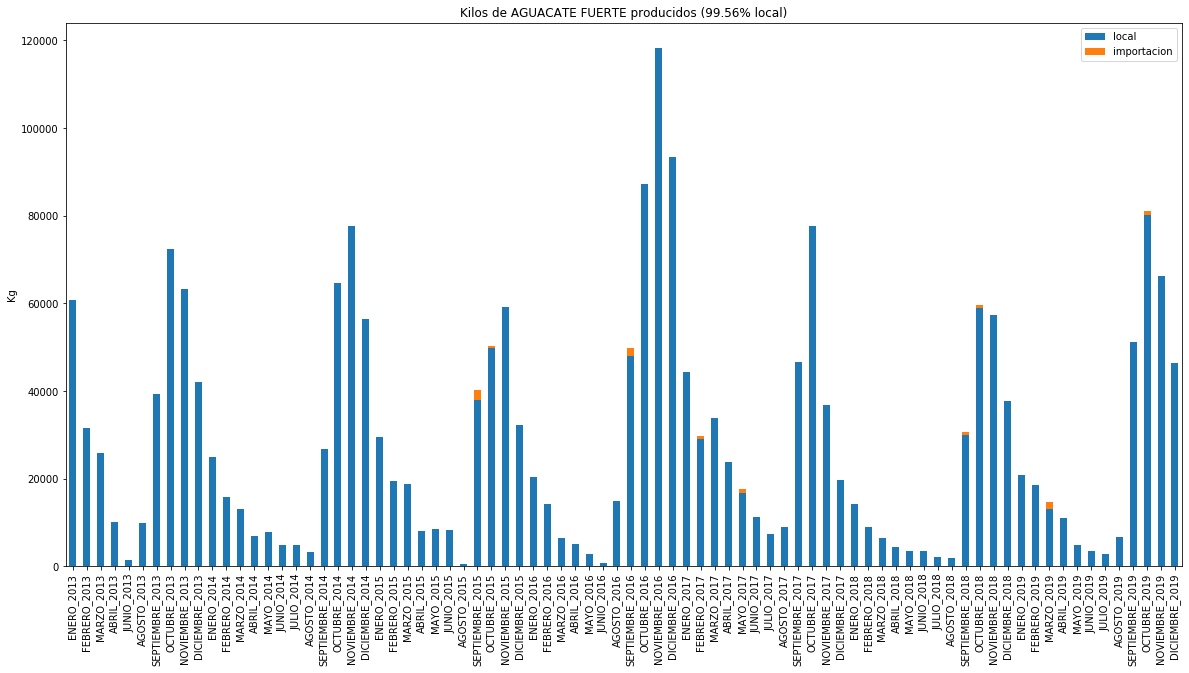

In [112]:
# Let's plot some results...
kilos = kilosTimeSeries[producto]
df = pd.DataFrame({key: list(kilos[key].values()) for key in ['local', 'importacion']})
fraction_local = df.sum().local / df.sum().sum()
fraction_importacion = 1 - fraction_local
df.plot(kind='bar', stacked=True, figsize=(20,10))
plt.ylabel('Kg')
plt.title('Kilos de ' + codigos[producto] + ' producidos ' + f'({fraction_local * 100:.2f}% local)')
ind = np.arange(len(kilos['local']))
plt.xticks(ind, list(kilos['local'].keys()))
plt.show()

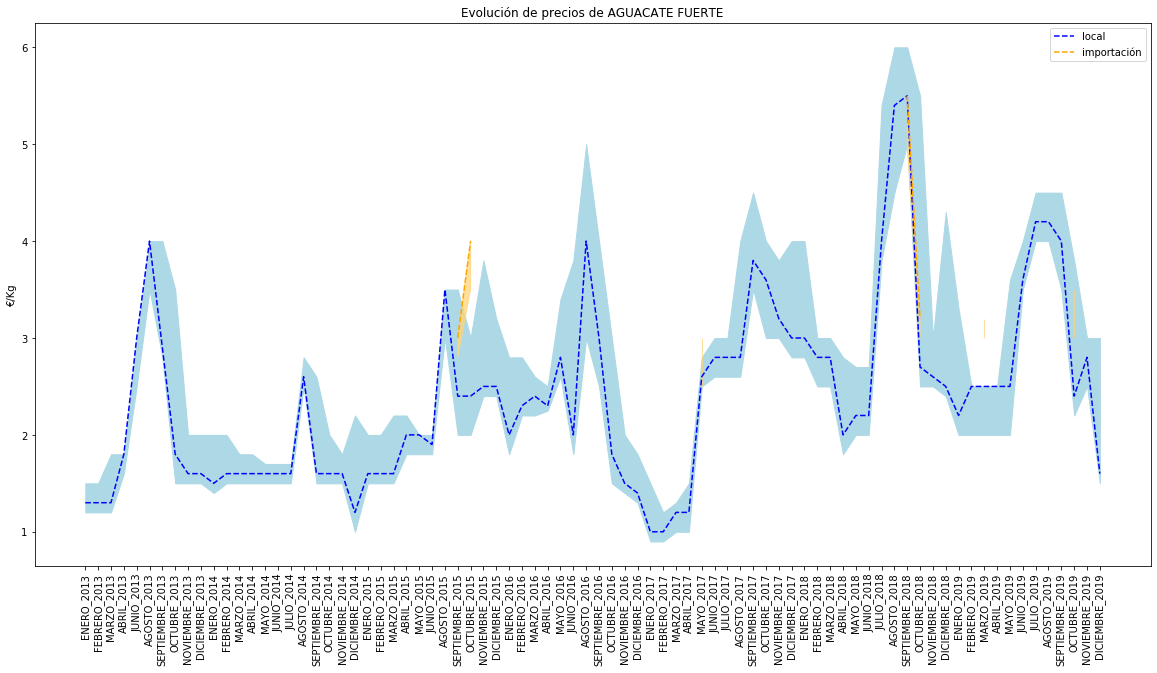

In [113]:
precios = preciosTimeSeries[producto]
plt.figure(figsize=(20, 10))
x = range(len(precios['moda']['local'].values()))
moda_local = list(precios['moda']['local'].values())
minimum_local = list(precios['min']['local'].values())
maximum_local = list(precios['max']['local'].values())

moda_impor = list(precios['moda']['importacion'].values())
minimum_impor = list(precios['min']['importacion'].values())
maximum_impor = list(precios['max']['importacion'].values())

plt.plot(x, moda_local, '--', color='blue', label='local')
# plt.plot(x, maximum_local, color='r')
# plt.plot(x, minimum_local, color='b')
plt.fill_between(x, minimum_local, maximum_local, color='lightblue')

plt.plot(x, moda_impor, '--', color='orange', label='importación')
# plt.plot(x, maximum_impor, color='violet')
# plt.plot(x, minimum_impor, color='orange')
plt.fill_between(x, minimum_impor, maximum_impor, color='#ffd57a', alpha=0.75)


plt.title(f'Evolución de precios de {codigos[producto]}')
plt.ylabel('€/Kg')
fechas = list(precios['moda']['local'].keys())
plt.xticks(range(len(fechas)), fechas, rotation=90)
plt.legend()
plt.show()

In [114]:
month_indices = {'ENERO':0, 'FEBRERO':1, 'MARZO':2, 'ABRIL':3, 
          'MAYO':4, 'JUNIO':5, 'JULIO':6, 'AGOSTO':7, 
          'SEPTIEMBRE':8, 'OCTUBRE':9, 'NOVIEMBRE':10, 'DICIEMBRE':11}
month_index = lambda m: month_indices[m]

In [120]:
# Finding picks in kilos time series
best_months = {}
for product_code in codigos.keys():
    best_months[product_code] = findMaximalProductionMonths(product_code)

In [21]:
# Filtering products by minimum of production
# Remove those with very little data
min_n_points = 30
filtered_kilosTimeSeries, filtered_preciosTimeSeries = {}, {}
filtered_codigos = {}
for producto in codigos.keys():
    kilos = kilosTimeSeries[producto]
    precios = preciosTimeSeries[producto]
    if len(kilos['local']) >= min_n_points:
        filtered_kilosTimeSeries[producto] = kilos
        filtered_preciosTimeSeries[producto] = precios
        filtered_codigos[producto] = codigos[producto]

In [22]:
# Write JSON files
import json
def myconverter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif np.isnan(obj):
            return float('nan')
        
with open('kilosTimeSeriesImputed.json', 'w') as json_file:
    json_file.writelines("kilos = ")
    json.dump(filtered_kilosTimeSeries, json_file, default=myconverter, allow_nan=True)
    json_file.close()
    
with open('preciosTimeSeriesImputed.json', 'w') as json_file:
    json_file.writelines("precios = ")
    json.dump(filtered_preciosTimeSeries, json_file, default=myconverter, allow_nan=True)
    json_file.close()
    
# with open('codigos.json', 'w') as json_file:
#     json_file.writelines("codigos = ")
#     json.dump(filtered_codigos, json_file, default=myconverter, allow_nan=True)
#     json_file.close()
    
#with open('mejores_meses.json', 'w') as json_file:
#    json.dump(best_months, json_file, default=myconverter, allow_nan=True)

# Cosas interesantes que explorar
Para la aplicación web me gustaría incluir lo siguiente:
1. Fracción de local vs importado para cada año y a lo largo de todos los años.
2. Gráfico interactivo para cada producto que muestre serie temporal de kilos y de precios. Además los productos se pueden agrupar por frutas, verduras y quizá tubérculos.
3. Estimación de la mejor temporada, e.g. mes, para comprar un producto, cuando tiene su máximo de producto, para cada producto en la lista.
4. Mostrar algunos casos curiosos, como tomates cherry que se han dejado de producir en la isla en los últimos años, o la suplantación con productos importados en los momentos en los que la producción es baja en la isla, como en el caso de la cebolla. También el caso de las dos variedades de aguacate que tiene ciclos de producción complementarios.
5. Mostrar lista de productos locales que genealmente son siempre mas caros que los importados, como el apio y la zanahoria de primera
6. Mostrar que productos son fundamentalmente locales y cuales importados
7. Localizar frutas y verduras en el calendario basandose en los mejores meses.